In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
# ADK built-in search tool and wrapper
from google.adk.tools import google_search
from google.adk.tools.agent_tool import AgentTool


In [39]:
# ==========================================
# Enterprise Agent System (EAS) - Data Analytics
# Powered by Google ADK (Agent Development Kit)
# ==========================================

# ⚙️ Section 1: Setup
# ==========================================

# 1.1: Install dependencies (already included in Kaggle)
# pip install google-adk google-genai duckdb pandas matplotlib seaborn

# 1.2: Configure Gemini API Key
import os
try:
    # Kaggle: store your secrets via "Add-ons -> Secrets" or use the kaggle_secrets client
    # If you're not on Kaggle, set the environment variable before running: export GOOGLE_API_KEY="..."
    from kaggle_secrets import UserSecretsClient
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Gemini API key setup complete (from Kaggle secrets).")
except Exception:
    # Fallback: read from environment or print an instruction
    if os.environ.get("GOOGLE_API_KEY"):
        print("✅ Gemini API key found in environment variables.")
    else:
        print("🔑 Authentication Warning: 'GOOGLE_API_KEY' not found. Please add it to Kaggle secrets or set environment variable.")

# ==========================================
# Section 1.3: Import ADK Components
# ==========================================

import pandas as pd
import numpy as np
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from datetime import datetime, timedelta
import warnings
import time
warnings.filterwarnings('ignore')

# Import ADK components
from google.adk.agents import Agent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.genai import types

# Use FunctionTool (ADK's pattern for custom tools)
from google.adk.tools import FunctionTool

# Import google_search built-in and AgentTool wrapper
# Note: if your ADK version exposes different names, adjust accordingly.
from google.adk.tools import google_search
from google.adk.tools.agent_tool import AgentTool

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries and ADK components imported successfully.")

# ==========================================
# Section 1.5: Configure Retry Options
# ==========================================

retry_config = types.HttpRetryOptions(
    attempts=5,
    exp_base=7,
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504]
)

print("✅ Retry configuration set.")

# ==========================================
# Section 2: Create Sample Dataset
# ==========================================

def create_sample_data():
    """Create a sample sales dataset for demonstration"""
    np.random.seed(42)
    
    # Generate dates
    dates = pd.date_range(start='2023-01-01', end='2024-12-01', freq='D')
    
    # Categories and products
    categories = ['Electronics', 'Clothing', 'Home & Garden', 'Sports', 'Books']
    products = {
        'Electronics': ['Laptop', 'Phone', 'Tablet', 'Headphones', 'Camera'],
        'Clothing': ['Shirt', 'Pants', 'Dress', 'Jacket', 'Shoes'],
        'Home & Garden': ['Furniture', 'Decor', 'Tools', 'Plants', 'Lighting'],
        'Sports': ['Bike', 'Weights', 'Yoga Mat', 'Running Shoes', 'Tennis Racket'],
        'Books': ['Fiction', 'Non-Fiction', 'Educational', 'Comics', 'Magazines']
    }
    
    regions = ['North', 'South', 'East', 'West']
    
    # Generate sales data
    data = []
    for _ in range(5000):
        date = np.random.choice(dates)
        category = np.random.choice(categories)
        product = np.random.choice(products[category])
        region = np.random.choice(regions)
        quantity = np.random.randint(1, 20)
        
        # Price varies by category
        base_prices = {
            'Electronics': (200, 2000),
            'Clothing': (20, 200),
            'Home & Garden': (30, 500),
            'Sports': (50, 800),
            'Books': (10, 50)
        }
        
        price = np.random.uniform(*base_prices[category])
        revenue = quantity * price
        cost = revenue * np.random.uniform(0.4, 0.7)
        profit = revenue - cost
        
        data.append({
            'date': date,
            'category': category,
            'product': product,
            'region': region,
            'quantity': quantity,
            'price': round(price, 2),
            'revenue': round(revenue, 2),
            'cost': round(cost, 2),
            'profit': round(profit, 2)
        })
    
    df = pd.DataFrame(data)
    df = df.sort_values('date').reset_index(drop=True)
    
    return df

# Create and store sample data
sales_df = create_sample_data()
print(f"✅ Sample dataset created: {len(sales_df)} records")
print(f"📊 Date range: {sales_df['date'].min()} to {sales_df['date'].max()}")
print(f"💰 Total revenue: ${sales_df['revenue'].sum():,.2f}")
print("\n📋 Dataset preview:")
print(sales_df.head(5))

# ==========================================
# Section 3: Initialize DuckDB Database
# ==========================================

# Create in-memory DuckDB database
conn = duckdb.connect(':memory:')

# Register the DataFrame as a view/table
conn.register('sales', sales_df)

print("✅ DuckDB database initialized with 'sales' table")

# ==========================================
# Section 4: Create Custom Tools for ADK
# ==========================================

def get_schema_info():
    """Get database schema information"""
    schema_info = f"""
    Table: sales
    Columns:
    - date (DATE): Transaction date
    - category (VARCHAR): Product category (Electronics, Clothing, Home & Garden, Sports, Books)
    - product (VARCHAR): Product name
    - region (VARCHAR): Sales region (North, South, East, West)
    - quantity (INTEGER): Quantity sold
    - price (FLOAT): Unit price
    - revenue (FLOAT): Total revenue
    - cost (FLOAT): Total cost
    - profit (FLOAT): Total profit
    
    Sample data (first 3 rows):
    {sales_df.head(3).to_string()}
    """
    return schema_info

# We'll define two plain Python functions and register them as FunctionTool instances

def execute_sql_tool(sql_query: str) -> str:
    """
    Execute SQL query on the sales database and return results as a string.
    """
    try:
        # Clean the SQL query
        sql_query = sql_query.strip()
        sql_query = re.sub(r'^```sql\s*', '', sql_query)
        sql_query = re.sub(r'^```\s*', '', sql_query)
        sql_query = re.sub(r'\s*```$', '', sql_query)
        
        # Execute query
        result = conn.execute(sql_query).fetchdf()
        
        if len(result) == 0:
            return "Query executed successfully but returned no results."
        
        output = f"Query returned {len(result)} rows.\n\n"
        output += result.to_string(index=False)
        
        return output
        
    except Exception as e:
        return f"SQL Error: {str(e)}"


def execute_pandas_tool(python_code: str) -> str:
    """
    Execute Pandas code on the sales dataframe and return results.
    The code should assign the final output to a variable named 'result'.
    """
    try:
        # Clean the code
        python_code = python_code.strip()
        python_code = re.sub(r'^```python\s*', '', python_code)
        python_code = re.sub(r'^```\s*', '', python_code)
        python_code = re.sub(r'\s*```$', '', python_code)
        
        # Execute code in a controlled namespace
        local_vars = {'df': sales_df.copy(), 'pd': pd, 'np': np}
        exec(python_code, {}, local_vars)
        result = local_vars.get('result', None)
        
        if result is None:
            return "Code executed but no 'result' variable was set."
        
        if isinstance(result, pd.DataFrame):
            output = f"Result DataFrame with {len(result)} rows:\n\n"
            output += result.to_string(index=False)
            return output
        else:
            return str(result)
            
    except Exception as e:
        return f"Python Error: {str(e)}"

# Wrap functions with FunctionTool to make them available to agents
sql_tool = FunctionTool(func=execute_sql_tool)
pandas_tool = FunctionTool(func=execute_pandas_tool)

print("✅ Custom ADK FunctionTools created successfully.")

# ==========================================
# Section 5: Enterprise Agent System with ADK
# ==========================================

class DataAnalyticsAgent:
    """
    Enterprise Data Analytics Agent using Google ADK
    """
    
    def __init__(self, df):
        self.df = df
        self.conversation_history = []
        
        # Initialize Gemini model with retry config
        self.model = Gemini(
            model_name="gemini-2.0-flash-exp",
            http_options=retry_config
        )
        
        # ---------------------------
        # GOOGLE SEARCH AGENT (INSIDE CLASS)
        # ---------------------------
        # Create a specialized search agent that uses the google_search tool.
        # This agent will be wrapped as an AgentTool so other agents can call it.
        self.search_agent = Agent(
            name="search_agent",
            description="Search specialist using Google Search grounding",
            model=Gemini(
                model_name="gemini-2.5-flash-lite",
                http_options=retry_config
            ),
            instruction=(
                "You are a search specialist. Use the google_search tool to fetch up-to-date info and return concise summaries."
            ),
            tools=[google_search]
        )
        
        # Wrap the search agent as a tool so other agents can call it
        self.search_tool = AgentTool(self.search_agent)
        
        # Create SQL Analysis Agent (include search_tool)
        self.sql_agent = Agent(
            name="sql_analyst",
            description="Expert SQL analyst for database queries",
            model=self.model,
            instruction=f"""You are an expert SQL analyst specializing in sales data analysis.

Database Schema:
{get_schema_info()}

Your task:
1. Analyze the user's question carefully
2. Write a valid DuckDB SQL query to answer it
3. Use the execute_sql tool to run the query
4. Analyze the results and provide insights

Guidelines:
- Use appropriate aggregations (SUM, AVG, COUNT, etc.)
- Include GROUP BY, ORDER BY, and LIMIT as needed
- Use DATE functions for time-based analysis
- Calculate profit margins as (profit/revenue * 100)
- If the question requires current / external info, use the search tool
- Always provide clear, actionable insights

Be concise but thorough in your analysis.""",
            tools=[sql_tool, self.search_tool]
        )
        
        # Create Pandas Analysis Agent (include search_tool)
        self.pandas_agent = Agent(
            name="pandas_analyst",
            description="Expert Python data analyst specializing in Pandas",
            model=self.model,
            instruction=f"""You are an expert Python data analyst specializing in Pandas.

Available DataFrame: 'df'
Columns: {list(df.columns)}

Your task:
1. Analyze the user's question
2. Write Pandas code to answer it
3. Store results in 'result' variable
4. Use the execute_pandas tool to run the code
5. Analyze and explain the results

Guidelines:
- Use Pandas best practices
- Handle data types appropriately
- Use vectorized operations
- If external/current info is needed, use the search tool
- Always store final result in 'result' variable

Be clear and provide actionable insights.""",
            tools=[pandas_tool, self.search_tool]
        )
        
        # Create runner (provide app_name and a default agent)
        self.runner = InMemoryRunner(app_name="EAS", agent=self.sql_agent)
        
        print("✅ ADK Agents initialized successfully.")
    
    def _create_visualization(self, result_text, query):
        """Create visualization from results (placeholder)"""
        try:
            # For now this is a placeholder — parse result_text to build real plots when needed
            return None
        except Exception:
            return None
    
    def analyze(self, user_query, method='sql', verbose=True):
        """
        Main analysis method using ADK agents
        
        Parameters:
        - user_query: Natural language query
        - method: 'sql' or 'pandas'
        - verbose: Print detailed output
        """
        
        if verbose:
            print("="*80)
            print(f"🔍 ANALYZING QUERY: {user_query}")
            print(f"📊 Method: {method.upper()}")
            print("="*80)
        
        result_data = {
            'query': user_query,
            'method': method,
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        
        try:
            # Select agent based on method
            agent = self.sql_agent if method == 'sql' else self.pandas_agent
            
            if verbose:
                print(f"\n🤖 Using {agent.name} agent...")
                print("⚡ Processing query with ADK...\n")
            
            # Try to use run_debug (async) if available to get detailed trace; fallback to run(...)
            result = None
            if hasattr(self.runner, 'run_debug'):
                # run_debug is async — call it from sync code
                import asyncio
                try:
                    loop = asyncio.get_event_loop()
                    if loop.is_running():
                        # In some environments (notebooks), loop is already running; create new task and wait
                        coro = self.runner.run_debug(user_query, agent=agent)
                        # Use asyncio.run if no running loop, else run until complete
                        result = asyncio.get_event_loop().run_until_complete(coro)
                    else:
                        result = loop.run_until_complete(self.runner.run_debug(user_query, agent=agent))
                except RuntimeError:
                    # If event loop issues occur, fallback to synchronous run
                    result = self.runner.run(user_prompt=user_query, agent=agent)
                except Exception as e:
                    # If run_debug fails, fallback
                    result = f"Runner run_debug failed: {e}"
            else:
                # Fallback synchronous runner call
                result = self.runner.run(user_prompt=user_query, agent=agent)
            
            if verbose:
                print("="*80)
                print("💡 AGENT RESPONSE:")
                print("="*80)
                print(result)
                print("="*80)
            
            result_data['agent_response'] = result
            
            # Store in history
            self.conversation_history.append(result_data)
            
            return result_data
            
        except Exception as e:
            if verbose:
                print(f"❌ Error during analysis: {str(e)}")
            return None
    
    def get_summary_statistics(self):
        """Get overall summary statistics"""
        print("\n📊 DATASET SUMMARY STATISTICS")
        print("="*80)
        
        print(f"Total Records: {len(self.df):,}")
        print(f"Date Range: {self.df['date'].min()} to {self.df['date'].max()}")
        print(f"\nTotal Revenue: ${self.df['revenue'].sum():,.2f}")
        print(f"Total Profit: ${self.df['profit'].sum():,.2f}")
        print(f"Profit Margin: {(self.df['profit'].sum() / self.df['revenue'].sum() * 100):.2f}%")
        
        print("\n📦 By Category:")
        category_summary = self.df.groupby('category').agg({
            'revenue': 'sum',
            'profit': 'sum',
            'quantity': 'sum'
        }).round(2)
        print(category_summary)
        
        print("\n🌍 By Region:")
        region_summary = self.df.groupby('region').agg({
            'revenue': 'sum',
            'profit': 'sum'
        }).round(2)
        print(region_summary)
        
        print("="*80)
    
    def run_demo_queries(self):
        """Run demonstration queries"""
        print("\n" + "🔹"*40)
        print("DEMO QUERY 1: Top Performing Categories")
        print("🔹"*40)
        self.analyze("Show me the top 5 categories by total revenue with their profit margins", method='sql')
        
        time.sleep(2)
        
        print("\n" + "🔹"*40)
        print("DEMO QUERY 2: Regional Performance")
        print("🔹"*40)
        self.analyze("Compare revenue across all regions and show which region is most profitable", method='sql')
        
        time.sleep(2)
        
        print("\n" + "🔹"*40)
        print("DEMO QUERY 3: Monthly Revenue Trends")
        print("🔹"*40)
        self.analyze("Show monthly revenue trends for 2024", method='sql')

# Initialize the agent
print("\n🚀 Initializing Enterprise Agent System with ADK...")
agent = DataAnalyticsAgent(sales_df)

# Get summary statistics
agent.get_summary_statistics()

# ==========================================
# Section 6: Interactive Query Interface
# ==========================================

def interactive_mode():
    """Run the agent in interactive mode"""
    print("\n" + "="*80)
    print("🤖 INTERACTIVE MODE")
    print("="*80)
    print("Ask questions about your data in natural language.")
    print("Type 'exit' to quit, 'summary' for statistics, 'history' to see past queries.")
    print("="*80 + "\n")
    
    while True:
        user_input = input("\n💬 Your query: ").strip()
        
        if not user_input:
            continue
        
        if user_input.lower() == 'exit':
            print("👋 Goodbye!")
            break
        
        if user_input.lower() == 'summary':
            agent.get_summary_statistics()
            continue
        
        if user_input.lower() == 'history':
            print("\n📜 Query History:")
            for i, item in enumerate(agent.conversation_history, 1):
                print(f"{i}. {item['query']} ({item['timestamp']})")
            continue
        
        method_input = input("Choose method (1=SQL, 2=Pandas) [default=1]: ").strip()
        method = 'pandas' if method_input == '2' else 'sql'
        
        agent.analyze(user_input, method=method)
        
        time.sleep(1)

print("\n✅ Enterprise Agent System setup complete!")
print("\n📌 USAGE:")
print("  • Run demo queries: agent.run_demo_queries()")
print("  • Interactive mode: interactive_mode()")
print("  • Custom query: agent.analyze('your query here', method='sql')")
print("\n⚠️  Note: Demo queries include short delays to respect API rate limits.")


✅ Gemini API key setup complete (from Kaggle secrets).
✅ All libraries and ADK components imported successfully.
✅ Retry configuration set.
✅ Sample dataset created: 5000 records
📊 Date range: 2023-01-01 00:00:00 to 2024-12-01 00:00:00
💰 Total revenue: $19,418,238.34

📋 Dataset preview:
        date       category   product region  quantity    price  revenue  \
0 2023-01-01    Electronics     Phone  South         3  1704.06  5112.18   
1 2023-01-01       Clothing     Dress   East        13   138.75  1803.77   
2 2023-01-01  Home & Garden  Lighting   West         5   301.28  1506.39   
3 2023-01-01    Electronics    Laptop   West        12   208.59  2503.04   
4 2023-01-01  Home & Garden  Lighting   West        17    68.96  1172.30   

      cost   profit  
0  2628.65  2483.53  
1   896.61   907.17  
2   760.08   746.31  
3  1051.27  1451.77  
4   654.74   517.56  
✅ DuckDB database initialized with 'sales' table
✅ Custom ADK FunctionTools created successfully.

🚀 Initializing Enterpris

In [40]:
# run one query (prints inside analyze because verbose=True)
out = agent.analyze("Show me top 5 categories by revenue", method='sql', verbose=True)

# the returned object contains metadata
print("Returned dict keys:", out.keys())
# agent response object (raw)
print(out['agent_response'])


🔍 ANALYZING QUERY: Show me top 5 categories by revenue
📊 Method: SQL

🤖 Using sql_analyst agent...
⚡ Processing query with ADK...

💡 AGENT RESPONSE:
Runner run_debug failed: Runner.run_debug() got an unexpected keyword argument 'agent'
Returned dict keys: dict_keys(['query', 'method', 'timestamp', 'agent_response'])
Runner run_debug failed: Runner.run_debug() got an unexpected keyword argument 'agent'


In [12]:
from pprint import pprint
pprint(agent.conversation_history[-1])   # last record


{'agent_response': 'Runner run_debug failed: Runner.run_debug() got an '
                   "unexpected keyword argument 'agent'",
 'method': 'sql',
 'query': 'Show me top 5 categories by revenue',
 'timestamp': '2025-12-01 11:47:39'}


In [41]:
import asyncio, json, textwrap
from pprint import pprint

def format_runner_response(resp):
    """
    Defensive formatter for typical ADK runner returns.
    Tries to pretty-print debug/action traces if present; otherwise str(resp).
    """
    try:
        # If response is a dict-like with keys we expect, format them
        if isinstance(resp, dict):
            # common ADK debug field names vary; try likely ones
            for k in ('debug', 'actions', 'observations', 'result', 'output'):
                if k in resp:
                    print(f"--- {k.upper()} ---")
                    pprint(resp[k])
            print("\n--- FULL RESPONSE (dict) ---")
            pprint(resp)
            return
        # if it's an object with attributes, print repr and any helpful attrs
        if hasattr(resp, '__dict__'):
            print("Object repr:", repr(resp))
            for a in ('actions', 'debug', 'reply', 'output'):
                if hasattr(resp, a):
                    print(f"\n--- {a} ---")
                    pprint(getattr(resp, a))
            return
    except Exception as e:
        print("Formatter error:", e)

    # fallback
    print("Response:")
    print(resp)

def ask_agent(prompt, agent_obj=None, use_debug=True):
    """
    Run the prompt using run_debug (if available) and pretty-print the result.
    Falls back to runner.run.
    """
    if agent_obj is None:
        agent_obj = agent.sql_agent

    runner = agent.runner
    print(f"\n>>> Asking agent '{agent_obj.name}': {prompt}\n")
    resp = None

    # Prefer run_debug if available
    if hasattr(runner, 'run_debug') and use_debug:
        try:
            loop = asyncio.get_event_loop()
            if loop.is_running():
                # in notebooks with an active loop, run until complete using new task
                coro = runner.run_debug(prompt, agent=agent_obj)
                resp = loop.run_until_complete(coro)
            else:
                resp = loop.run_until_complete(runner.run_debug(prompt, agent=agent_obj))
        except Exception as e:
            print("run_debug failed, falling back to run():", e)
            resp = runner.run(user_prompt=prompt, agent=agent_obj)
    else:
        resp = runner.run(user_prompt=prompt, agent=agent_obj)

    # store in history similar to agent.analyze
    record = {'query': prompt, 'agent': agent_obj.name, 'response_raw': resp, 'time': datetime.now().isoformat()}
    agent.conversation_history.append(record)

    # Pretty print
    format_runner_response(resp)
    return resp


,category,revenue,profit
0,Electronics,11001224.96,4964637.52
1,Sports,4453208.04,2008633.93
2,Home & Garden,2513221.84,1122408.33
3,Clothing,1129760.90,509087.49
4,Books,320822.60,144582.12


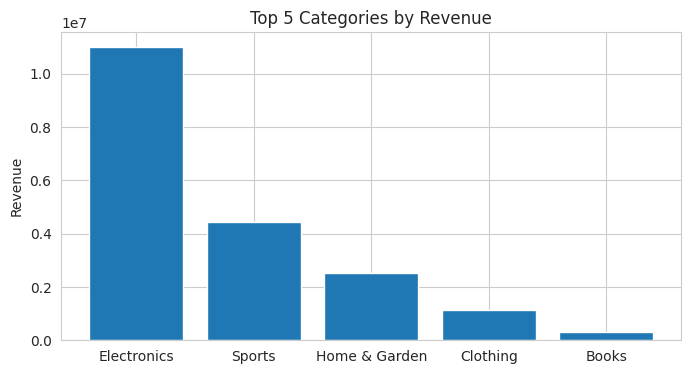

In [15]:
# Direct SQL example (no agent)
df_top = conn.execute("""
    SELECT category, SUM(revenue) AS revenue, SUM(profit) AS profit
    FROM sales
    GROUP BY category
    ORDER BY revenue DESC
    LIMIT 5
""").fetchdf()
display(df_top)   # or print(df_top)

# Plot in notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(df_top['category'], df_top['revenue'])
ax.set_title('Top 5 Categories by Revenue')
ax.set_ylabel('Revenue')
plt.show()


In [16]:
# If execute_sql_tool returns textual table, but you want DataFrame, run sql directly:
sql = "SELECT category, SUM(revenue) AS revenue FROM sales GROUP BY category ORDER BY revenue DESC LIMIT 10"
df = conn.execute(sql).fetchdf()
display(df)


,category,revenue
0,Electronics,11001224.96
1,Sports,4453208.04
2,Home & Garden,2513221.84
3,Clothing,1129760.90
4,Books,320822.60


In [17]:
!adk create sample-agent --model gemini-2.5-flash-lite --api_key $GOOGLE_API_KEY



Agent created in /kaggle/working/sample-agent:
- .env
- __init__.py
- agent.py



In [19]:
!pip install --upgrade google-adk google-genai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 33.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.2/261.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: google-genai
    Found existing installation: google-genai 1.48.0
    Uninstalling google-genai-1.48.0:
      Successfully uninstalled google-genai-1.48.0
  Attempting uninstall: google-adk
    Found existing installation: google-adk 1.18.0
    Uninstalling google-adk-1.18.0:
      Successfully uninstalled google-adk-1.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.


In [20]:
import os

def get_kaggle_adk_url(port=8000):
    base = os.environ.get("KAGGLE_URL_BASE", "")
    if not base:
        # Not running inside Kaggle environment
        return f"http://127.0.0.1:{port}"
    
    # Kaggle injects this environment variable for notebook proxying
    return f"{base}/{port}/"
    
url_prefix = get_kaggle_adk_url()
url_prefix


'https://www.kaggle.com/8000/'

In [21]:
!adk web --url_prefix {url_prefix}


/usr/local/lib/python3.11/dist-packages/google/adk/cli/fast_api.py:138: UserWarning: [EXPERIMENTAL] InMemoryCredentialService: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  credential_service = InMemoryCredentialService()
/usr/local/lib/python3.11/dist-packages/google/adk/auth/credential_service/in_memory_credential_service.py:33: UserWarning: [EXPERIMENTAL] BaseCredentialService: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  super().__init__()
INFO:     Started server process [214]
INFO:     Waiting for application startup.

+-----------------------------------------------------------------------------+
| ADK Web Server started                                                      |
|                                                                             |
| For local testing, access at http:

,category,revenue,profit
0,Electronics,11001224.96,4964637.52
1,Sports,4453208.04,2008633.93
2,Home & Garden,2513221.84,1122408.33
3,Clothing,1129760.90,509087.49
4,Books,320822.60,144582.12


<Axes: title={'center': 'Top 5 Categories by Revenue'}, xlabel='category'>

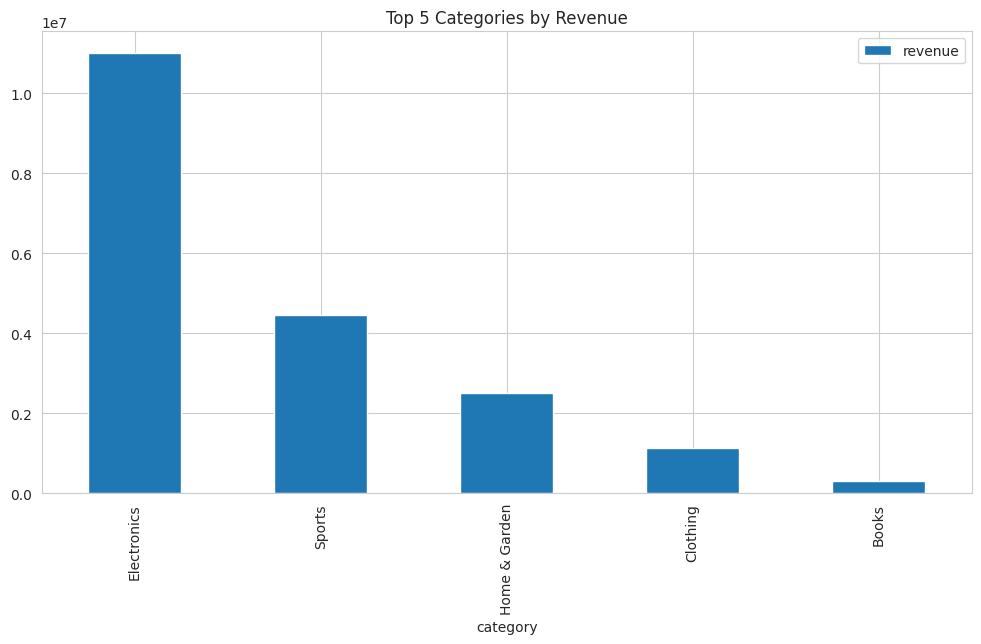

In [23]:
df_top = conn.execute("""
SELECT category, SUM(revenue) revenue, SUM(profit) profit
FROM sales
GROUP BY category
ORDER BY revenue DESC
LIMIT 5
""").fetchdf()
display(df_top)
df_top.plot(kind='bar', x='category', y='revenue', title='Top 5 Categories by Revenue')


In [42]:
# Paste this in a notebook cell and run it.
import types
import asyncio
from datetime import datetime
import traceback

def patched_analyze(self, user_query, method='sql', verbose=True):
    """
    Robust analyze method that works with several runner.run/run_debug signatures.
    Bound dynamically to existing agent instance.
    """
    if verbose:
        print("="*80)
        print(f"🔍 ANALYZING QUERY: {user_query}")
        print(f"📊 Method: {method.upper()}")
        print("="*80)

    result_data = {
        'query': user_query,
        'method': method,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }

    try:
        agent_obj = self.sql_agent if method == 'sql' else self.pandas_agent

        if verbose:
            print(f"\n🤖 Using {agent_obj.name} agent...")
            print("⚡ Processing query with ADK...\n")

        result = None

        # If runner has run_debug (async), try that first
        runner = getattr(self, 'runner', None)
        if runner is None:
            raise RuntimeError("Agent has no attribute 'runner'")

        if hasattr(runner, 'run_debug'):
            try:
                # run_debug usually accepts (prompt, agent=...)
                coro = runner.run_debug(user_query, agent=agent_obj)
                # Use asyncio.run to run coroutine safely from notebook
                result = asyncio.run(coro)
            except TypeError:
                # try without agent kw
                coro = runner.run_debug(user_query)
                result = asyncio.run(coro)
            except Exception as e:
                # fallback to synchronous run below
                if verbose:
                    print("⚠ run_debug failed, falling back to runner.run():", e)

        # If result still None, try runner.run in different call styles
        if result is None:
            tried = []
            # Try common signatures in order
            try:
                result = runner.run(user_query, agent=agent_obj)
                tried.append("run(prompt, agent=...)")
            except TypeError as e:
                tried.append(f"run(prompt, agent=...) failed: {e}")
                try:
                    result = runner.run(user_query)
                    tried.append("run(prompt)")
                except TypeError as e2:
                    tried.append(f"run(prompt) failed: {e2}")
                    # Last resort: try run() with no args
                    try:
                        result = runner.run()
                        tried.append("run()")
                    except Exception as e3:
                        tried.append(f"run() failed: {e3}")
                        raise TypeError("All runner.run() call attempts failed: " + "; ".join(tried))

        if verbose:
            print("="*80)
            print("💡 AGENT RESPONSE:")
            print("="*80)
            print(result)
            print("="*80)

        result_data['agent_response'] = result
        # append to conversation_history if present
        if not hasattr(self, 'conversation_history'):
            self.conversation_history = []
        self.conversation_history.append(result_data)

        return result_data

    except Exception as e:
        # Return a dict with the traceback so the UI can display it clearly
        tb = traceback.format_exc()
        if verbose:
            print("❌ Error during analysis:\n", tb)
        return {'query': user_query, 'method': method, 'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"), 'agent_response': f"ERROR:\n{tb}"}

# Bind to your running agent instance
agent.analyze = types.MethodType(patched_analyze, agent)
print("✅ Patched agent.analyze successfully.")


✅ Patched agent.analyze successfully.


In [43]:
import inspect
runner = getattr(agent, 'runner', None)
print("runner object:", type(runner))
if runner is None:
    print("No runner found on agent.")
else:
    # show run signature if present
    if hasattr(runner, 'run'):
        try:
            print("runner.run signature:", inspect.signature(runner.run))
        except Exception as e:
            print("Could not inspect runner.run:", e)
    if hasattr(runner, 'run_debug'):
        try:
            print("runner.run_debug signature:", inspect.signature(runner.run_debug))
        except Exception as e:
            print("Could not inspect runner.run_debug:", e)


runner object: <class 'google.adk.runners.InMemoryRunner'>
runner.run signature: (*, user_id: 'str', session_id: 'str', new_message: 'types.Content', run_config: 'Optional[RunConfig]' = None) -> 'Generator[Event, None, None]'
runner.run_debug signature: (user_messages: 'str | list[str]', *, user_id: 'str' = 'debug_user_id', session_id: 'str' = 'debug_session_id', run_config: 'RunConfig | None' = None, quiet: 'bool' = False, verbose: 'bool' = False) -> 'list[Event]'


In [44]:
# Replace the existing run_query in your notebook (the Gradio app uses the function object already bound)
import traceback

def run_query_safe(query: str, method: str):
    if not query or query.strip() == "":
        return "Please enter a query."
    method_key = 'pandas' if method.lower().startswith('p') else 'sql'

    try:
        # call patched agent.analyze which returns a dict
        result = agent.analyze(query, method=method_key, verbose=True)
        # If agent.analyze returned dict with 'agent_response', format it
        if isinstance(result, dict):
            ar = result.get('agent_response', '')
            # If ar is a DataFrame or complex, convert safely to string
            try:
                return str(ar)
            except Exception:
                return repr(ar)
        else:
            # fallback: just stringify
            return str(result)
    except Exception as e:
        tb = traceback.format_exc()
        return f"UNHANDLED EXCEPTION:\n{tb}"

# If your Gradio Blocks object is `demo` and is already created, rebind the button:
# (This is optional — easiest is to re-create/re-launch demo after changing the function)
try:
    # If you have run the Gradio app code in the same notebook, replace the callback:
    run_btn  # this will exist if you defined it in the same cell
    run_btn.click(fn=run_query_safe, inputs=[query_input, method_radio], outputs=[output_area])
    print("✅ Rebound Gradio run button to run_query_safe.")
except Exception:
    print("⚠ Could not rebind buttons automatically. If demo not updated, re-create the UI cell and use run_query_safe.")
# After editing the functions and re-creating the Gradio Blocks 'demo'
demo.launch()   # do NOT use share=True in Kaggle


⚠ Could not rebind buttons automatically. If demo not updated, re-create the UI cell and use run_query_safe.
Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://ad949b4d8e689b1204.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
